![title](LLAMAS_llama.png)

# Introduction

This notebook explains use of the LLAMAS exposure time calculator (ETC).

The ETC is provided by the instrument team; it is based on laboratory data, and a working model of the instrument and Magellan telescopes. We are sharing it to help users plan proposals and observing runs.  It represents a best-effort attempt to simulate observations, but we cannot guarantee that it will provide accurate results for your use case until we have meausred accurate instrument throughput on the sky, at which point this repository will be updated.

Users are responsible for providing accurate input spectra on a grid of wavelength (in nm) versus flux in f_lambda units (erg/cm2/s/A).  

Good luck with your observation planning!

# Import libraries

After installing the llamas-etc package from github, start by loading relevant libraries.  The first two of these are specific to the llamas-etc.

In [1]:
import spectrograph as spec
import observe
import numpy as np
import matplotlib.pyplot as plt
from   astropy.table import Table

# Creating instances of the spectrographs

The first calls are to instantiate objects representing the three arms of the spectrographs: blue, green, and red. There is no requirement to run all three arms for the ETC, as they are treated separately.  By default LLAMAS observes all three simultaneously, however.  At this stage, these objects are mostly empty and will need to be populated with instrument data.

In [2]:
llamas_blue  = spec.Spectrograph('LLAMAS_BLUE')
llamas_green = spec.Spectrograph('LLAMAS_GREEN')
llamas_red   = spec.Spectrograph('LLAMAS_RED')

After the spectrograph objects are created, call the "build_model" method to read in relevant throughput and configuration data and create wavelength and throughput attributes for each channel. Running this method will print out a bunch of information about optical surfaces, which is normal, but unimportant for our purposes.

In [3]:
llamas_blue.build_model('llamas_blue.def')
llamas_green.build_model('llamas_green.def')
llamas_red.build_model('llamas_red.def')


 LLAMAS_BLUE
    MicroLens FusedSilica ECI_FusedSilica.txt ECI model
    MicroLens FusedSilica ECI_FusedSilica.txt ECI model
    Fiber_AR FusedSilica fiber_ar.txt ECI placeholder
    Fiber_AR FusedSilica fiber_ar.txt ECI placeholder
    Internal FusedSilica Polymicro_FBPI_8m.txt PolyMicro model
    Collimator FusedSilica dielectric_mirror.txt ECI2 model
    DichroicRG FusedSilica ECI_FusedSilica.txt ECI model
    DichroicBG FusedSilica ECI_FusedSilica.txt ECI model
    VPH_B 1200.0 420.0 0.0 VPHG/vph_wasach_blue_eavg.txt Wasach asbuilt
    Prism FusedSilica ECI_FusedSilica.txt ECI model
    L1 CaF2 ECI_FusedSilica.txt ECI placeholder
    L1 CaF2 ECI_FusedSilica.txt ECI placeholder
    L2 BAL35Y ECI_PBM8Y.txt ECI placeholder
    L2 BAL35Y ECI_PBM8Y.txt ECI placeholder
    L3 CaF2 ECI_FusedSilica.txt ECI placeholder
    L3 CaF2 ECI_FusedSilica.txt ECI placeholder
    L4 BSM51Y ECI_PBM8Y.txt ECI placeholder
    L4 BSM51Y ECI_PBM8Y.txt ECI placeholder
    L5 CaF2 ECI_FusedSilica.txt ECI p

# Loading your input model spectrum

Now we need to read in a model spectrum of the source to be observed.  We have provided an example model spectrum in the repository, consisting of a Type Ia supernova, scaled to 20th magnitude in R (but not redshifted). This is included to verify functionality of your installation for the ETC.

You will of course need to generate your own high-SNR model input spectrum specific to your application.  It must be converted into units of wavelength (in nm) vs. flux density in f_lambda units (erg/cm2/s/A), and would normally be formatted as a two-column astropy table object.

In [4]:
input_spectrum = Table.read("SN1a_R20mag.fits")

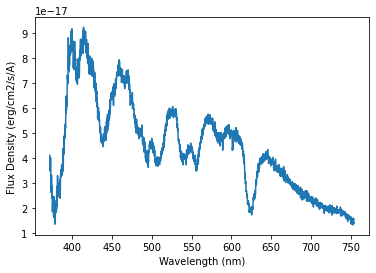

In [5]:
plt.plot(input_spectrum['wave(nm)'], input_spectrum['flux(erg/cm2/s/A)'])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux Density (erg/cm2/s/A)")
plt.show()

# Running the Exposure Time Calculator

Now we execute the simulated observation. This is done using the observe.observe_spectrum() function, which takes as inputs (a) the instrument object, (b) the exposure time, and (c+d) the wavelength and flux of your input model spectrum. The ETC will interpolate your input spectrum onto the wavelength grid appropriate to each channel of LLAMAS, and output a 2048-element vector corresponding to observed counts in one fiber.  

In [6]:
texp = 1200
blue_counts_electrons, blue_noise_electrons = observe.observe_spectrum(llamas_blue, texp, input_spectrum['wave(nm)'], input_spectrum['flux(erg/cm2/s/A)'])
green_counts_electrons, green_noise_electrons = observe.observe_spectrum(llamas_green, texp, input_spectrum['wave(nm)'], input_spectrum['flux(erg/cm2/s/A)'])
red_counts_electrons, red_noise_electrons = observe.observe_spectrum(llamas_red, texp, input_spectrum['wave(nm)'], input_spectrum['flux(erg/cm2/s/A)'])

The cell above runs the instrument simulator three times, once for each of the spectrograph channels.  The outputs are provided in units of photo-electrons of signal, and photo-electrons of noise.

# Plotting outputs

The SNR for your observation is the ratio of these two outputs.

The ETC accounts for the fact that the fiber's geometric image subtends slightly more than 2 pixels apiece in the dispersion and spatial directions, and takes in >1 pixel of the CCD's dark current and read noise accordingly.  

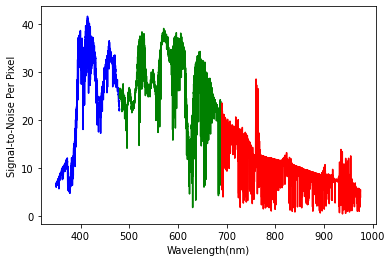

In [7]:
plt.plot(llamas_blue.waves, blue_counts_electrons/blue_noise_electrons, color='b')
plt.plot(llamas_green.waves, green_counts_electrons/green_noise_electrons, color='g')
plt.plot(llamas_red.waves, red_counts_electrons/red_noise_electrons, color='r')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Signal-to-Noise Per Pixel')
plt.show()

# Conclusion and Caveats

That's all there is to running the ETC!  

There are a few items to remember when interpreting these results:

1) The ETC assumes that all of the light goes down a single fiber, i.e. that the source is unresolved in the 0.75" spaxel. If your source is resolved, or the seeing is lousy, you will need to adjust these outputs accordingly and we have not yet implemented that functionality (though it would be straightforward to split the light across N fibers/spaxels).  

2) The ETC uses units of flux, and not surface brightness, but surface brightness is the more appropriate unit for resolved sources.  Future ETC versions may include surface brightness calculations, but intrepid users can implement this on their own using the following hints. Surface brightness can often be expressed in units of erg/cm2/s/A/square arcsec, or can be converted into these units from magnitudes per square arcsec or your unit of choice. It is your responsibility to convert into the first set of units (erg/cm2/s/A/sq.arcsec). Then, the subtended area of a fiber is provided as an attribute in the spectrograph object: llamas_blue.fiber.Afib, in square arcseconds. Multiply your surface brightness spectrum by this value, and then input that to the observe.observe_spectrum subroutine to output a correct SNR calculation!

3) Once again, we remind users that this is a best-effort estimate based on multiplying the measured and model curves for optical glasses, coatings, mirrors, the fibers, and geometric shadows.  Users are urged to plan conservatively for early observing runs, until the team has an opportunity to observe spectro-photometric standard stars on the sky. When those observations are taken we will update the ETC gitib repository with as-measured throughputs so that future observers can forecast with confidence.

Good luck with your observations and thanks for your interest in LLAMAS!